<a href="https://colab.research.google.com/github/Prab999/CSCI167/blob/main/project/Project167_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

from datasets import load_dataset
import numpy as np

In [2]:
ds = load_dataset("cifar10")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
# Basic CIFAR-10 transforms: ToTensor + Normalize
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
    ),
])

class Cifar10HFDataset(Dataset):
    def __init__(self, hf_split, transform=None):
        """
        hf_split: ds["train"] or ds["test"] from Hugging Face
        transform: torchvision transforms to apply to the image
        """
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        img = example["img"]
        label = example["label"]

        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [4]:
class DeepMLP_CIFAR10(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dims=None, num_classes=10):
        super().__init__()
        if hidden_dims is None:
            # Basic deep net: 3 hidden layers
            hidden_dims = [512, 256, 128]

        layers = []
        in_dim = input_dim

        # Hidden layers: (Ω, β) + ReLU
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        # Final output layer
        layers.append(nn.Linear(in_dim, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        logits = self.net(x)
        return logits

#adding dropout for testing
class DeepMLP_CIFAR10_Dropout(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dims=None, num_classes=10, dropout_p=0.3):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [512, 256, 128]

        layers = []
        in_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))
            in_dim = h

        # Final output layer
        layers.append(nn.Linear(in_dim, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        logits = self.net(x)
        return logits

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DeepMLP_CIFAR10().to(device)
model


Using device: cpu


DeepMLP_CIFAR10(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [6]:
# Hugging Face splits
train_hf = ds["train"]
test_hf  = ds["test"]

train_dataset = Cifar10HFDataset(train_hf, transform=cifar_transform)
test_dataset  = Cifar10HFDataset(test_hf,  transform=cifar_transform)

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

len(train_dataset), len(test_dataset)


(50000, 10000)

In [9]:
#Select proper model to run on, select loss and optimizer
model = DeepMLP_CIFAR10_Dropout(dropout_p=0.1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#parameter count
print("Model parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

Model parameters: 1.73889 M


In [11]:
#Go through mini batches
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for xb, yb in dataloader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        #clear gradients, forward pass, computing loss, backwardpass
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc

#validation
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for xb, yb in dataloader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    return epoch_loss, epoch_acc


In [13]:
num_epochs = 10

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch 01 | Train Loss: 1.6306, Train Acc: 0.4199 | Val Loss: 1.4948, Val Acc: 0.4750
Epoch 02 | Train Loss: 1.4749, Train Acc: 0.4791 | Val Loss: 1.4044, Val Acc: 0.5063
Epoch 03 | Train Loss: 1.3829, Train Acc: 0.5107 | Val Loss: 1.3719, Val Acc: 0.5167
Epoch 04 | Train Loss: 1.3068, Train Acc: 0.5388 | Val Loss: 1.3434, Val Acc: 0.5266
Epoch 05 | Train Loss: 1.2495, Train Acc: 0.5578 | Val Loss: 1.3180, Val Acc: 0.5294
Epoch 06 | Train Loss: 1.2003, Train Acc: 0.5751 | Val Loss: 1.3140, Val Acc: 0.5423
Epoch 07 | Train Loss: 1.1493, Train Acc: 0.5927 | Val Loss: 1.2851, Val Acc: 0.5504
Epoch 08 | Train Loss: 1.0978, Train Acc: 0.6126 | Val Loss: 1.3034, Val Acc: 0.5478
Epoch 09 | Train Loss: 1.0589, Train Acc: 0.6250 | Val Loss: 1.2899, Val Acc: 0.5536
Epoch 10 | Train Loss: 1.0177, Train Acc: 0.6384 | Val Loss: 1.2775, Val Acc: 0.5578


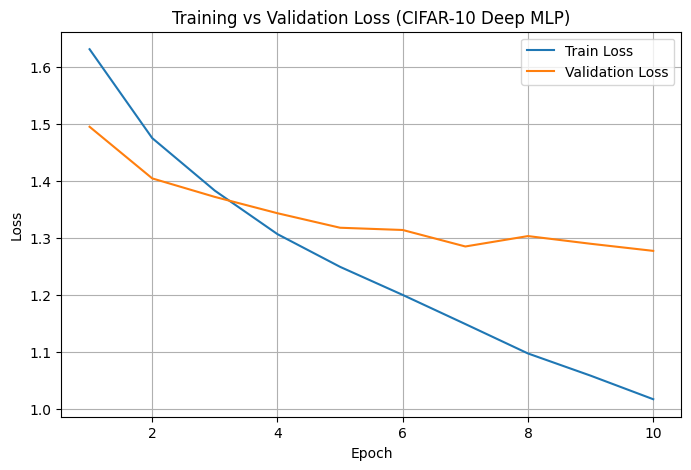

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CIFAR-10 Deep MLP)")
plt.legend()
plt.grid(True)
plt.show()

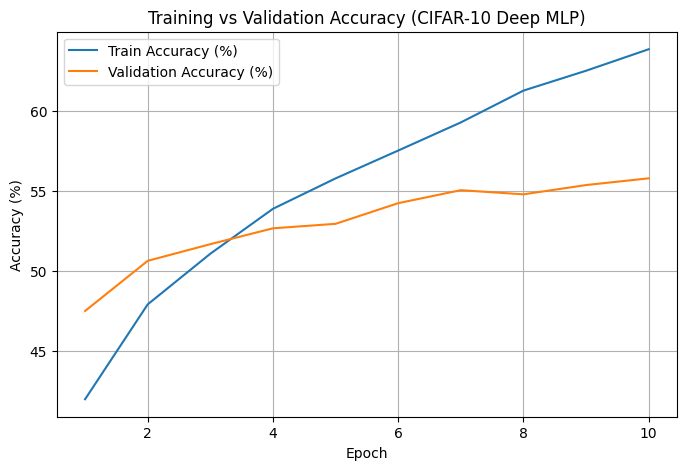

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, [a * 100 for a in train_accs], label="Train Accuracy (%)")
plt.plot(epochs, [a * 100 for a in val_accs],   label="Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy (CIFAR-10 Deep MLP)")
plt.legend()
plt.grid(True)
plt.show()